# 08 - Integration with Nowotschin et al., 2019

Workflow:

- [x] Harmony
- [x] SCVI
- [x] bbknn

Check if there is a batch effect

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import anndata
import pandas as pd
import scanpy as sc
import numpy as np

import scvi
from scvi.model.utils import mde

sc.set_figure_params(dpi_save=300)
sc.settings.figdir = "../reports/figures/08_nowo"

BATCH_KEY = 'batch'

Global seed set to 0


In [2]:
nowo = sc.read("../data/external/Nowotschin_et_al_2019/sc_endoderm_all_cells.h5ad")
nowo = nowo[nowo.obs.Timepoint.isin(['E3.5', 'E4.5'])].copy()

corrected_metadata = pd.read_csv('../data/external/Nowotschin_et_al_2019/e35_cell_types.csv', index_col=0)
nowo.obs.CellType = nowo.obs.CellType.astype(str)
nowo.obs.loc[corrected_metadata.index, 'CellType'] = corrected_metadata.CellType
nowo.obs.CellType = nowo.obs.CellType.astype('category')

nowo.obs['Stage'] = nowo.obs['Timepoint']

In [3]:
nowo

AnnData object with n_obs × n_vars = 1006 × 20897
    obs: 'Cluster', 'Timepoint', 'CellType', 'Stage'

In [4]:
nend = sc.read("../data/processed/00_merged.h5ad")
nend.var = nend.var.set_index("_index")

nend_processed = sc.read("../data/processed/07_normalized_data_filt.h5ad")
nend = nend[nend_processed.obs_names, nend_processed.var_names].copy()
nend.obs = nend_processed.obs[['Stage', 'Batch', 'seurat_clusters']].copy()

In [5]:
nend

AnnData object with n_obs × n_vars = 8847 × 32285
    obs: 'Stage', 'Batch', 'seurat_clusters'
    var: 'features'

## Integration

In [6]:
nowo.obs['experiment'] = 'Nowotschin et al., 2019'
nend.obs['experiment'] = 'nEnd'

nowo.obs['batch'] = nowo.obs.Timepoint.astype(str)
nend.obs['batch'] = nend.obs.Batch.astype(str)

nend.obs['Cluster'] = nend.obs.seurat_clusters.astype(str)

In [7]:
integ = nowo.concatenate(nend, batch_key=None)
integ.layers['counts'] = integ.X

integ.obs['ct'] = integ.obs.Cluster.astype(str)
integ.obs.loc[integ.obs.experiment == 'Nowotschin et al., 2019', 'ct'] = integ.obs.loc[integ.obs.experiment == 'Nowotschin et al., 2019', ['Timepoint', 'CellType']].agg('-'.join, axis=1)
integ.obs['ct'] = integ.obs['ct'].astype('category')

In [8]:
integ

AnnData object with n_obs × n_vars = 9853 × 19652
    obs: 'Cluster', 'Timepoint', 'CellType', 'Stage', 'experiment', 'batch', 'Batch', 'seurat_clusters', 'ct'
    var: 'features-1'
    layers: 'counts'

In [9]:
sc.pp.normalize_total(integ, target_sum=10_000)
sc.pp.log1p(integ)
integ.raw = integ

In [10]:
sc.pp.highly_variable_genes(
    integ,
    flavor="seurat_v3",
    n_top_genes=2_000,
    layer="counts",
    batch_key=BATCH_KEY,
    subset=True
)

In [11]:
sc.tl.pca(integ)

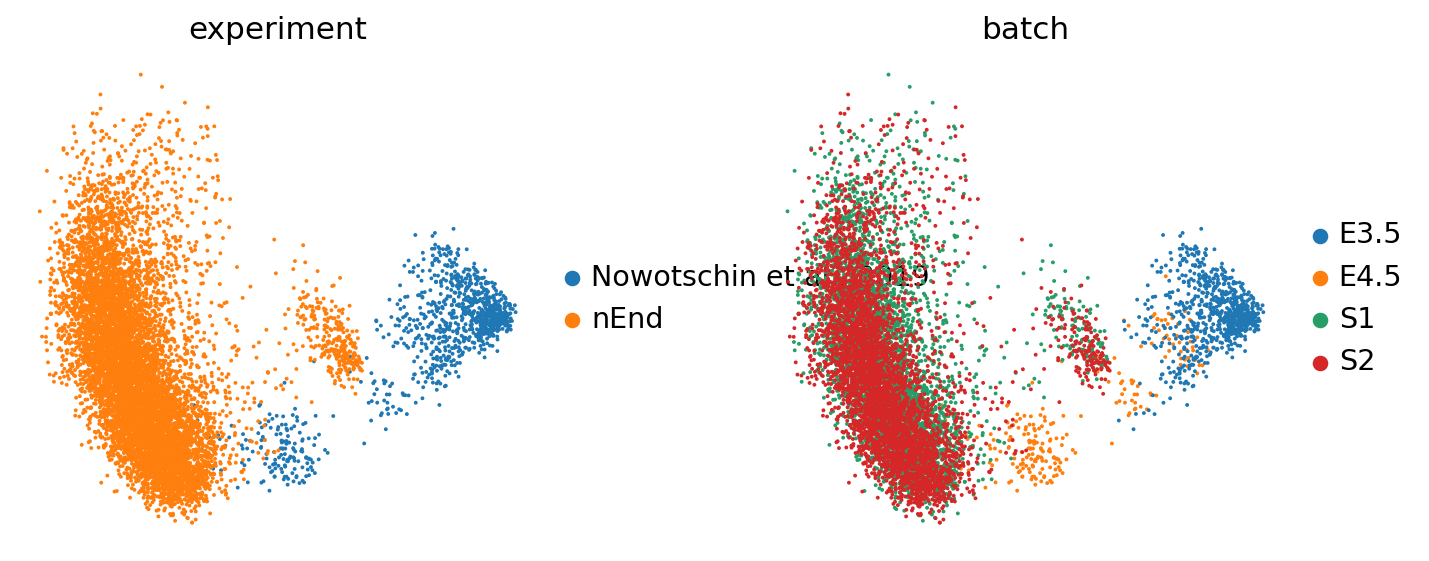

In [12]:
sc.pl.pca(integ, color=['experiment', 'batch'], frameon=False, wspace=0.3)

## 1. Harmony

In [13]:
import scanpy.external as sce

In [14]:
adata = integ.copy()

In [15]:
sce.pp.harmony_integrate(adata, key=BATCH_KEY)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2022-10-19 11:47:32,893 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2022-10-19 11:47:34,525 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2022-10-19 11:47:36,140 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2022-10-19 11:47:37,761 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2022-10-19 11:47:39,091 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2022-10-19 11:47:40,354 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2022-10-19 11:47:41,179 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2022-10-19 11:47:41,873 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2022-10-19 11:47:42,629 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2022-10-19 11:47:44,251 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2022-10-19 11:47:45,293 - harmonypy - 

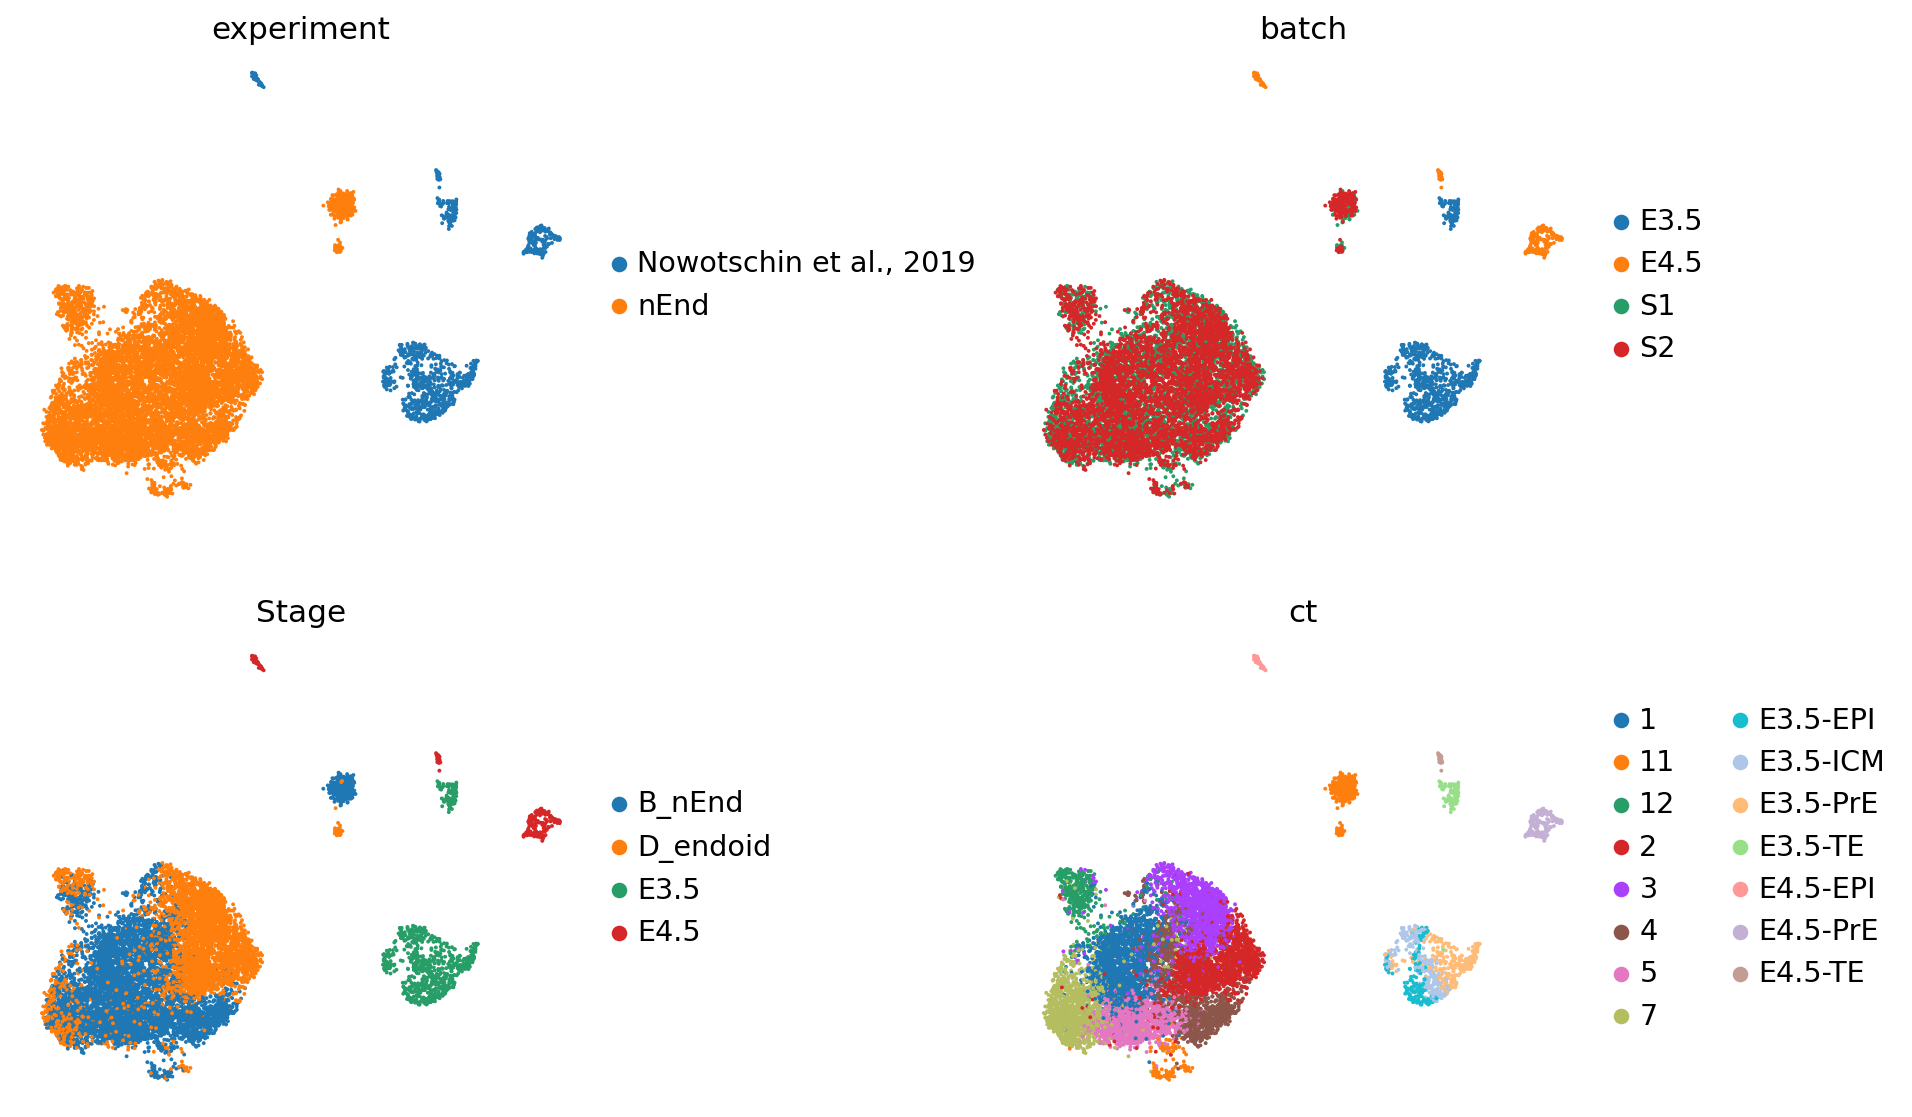

In [16]:
sc.pl.umap(adata, color=['experiment', 'batch', 'Stage', 'ct'], frameon=False, wspace=0.6, ncols=2, save='harmony')

In [17]:
sc.tl.draw_graph(adata)
sc.tl.paga(adata, groups='ct')

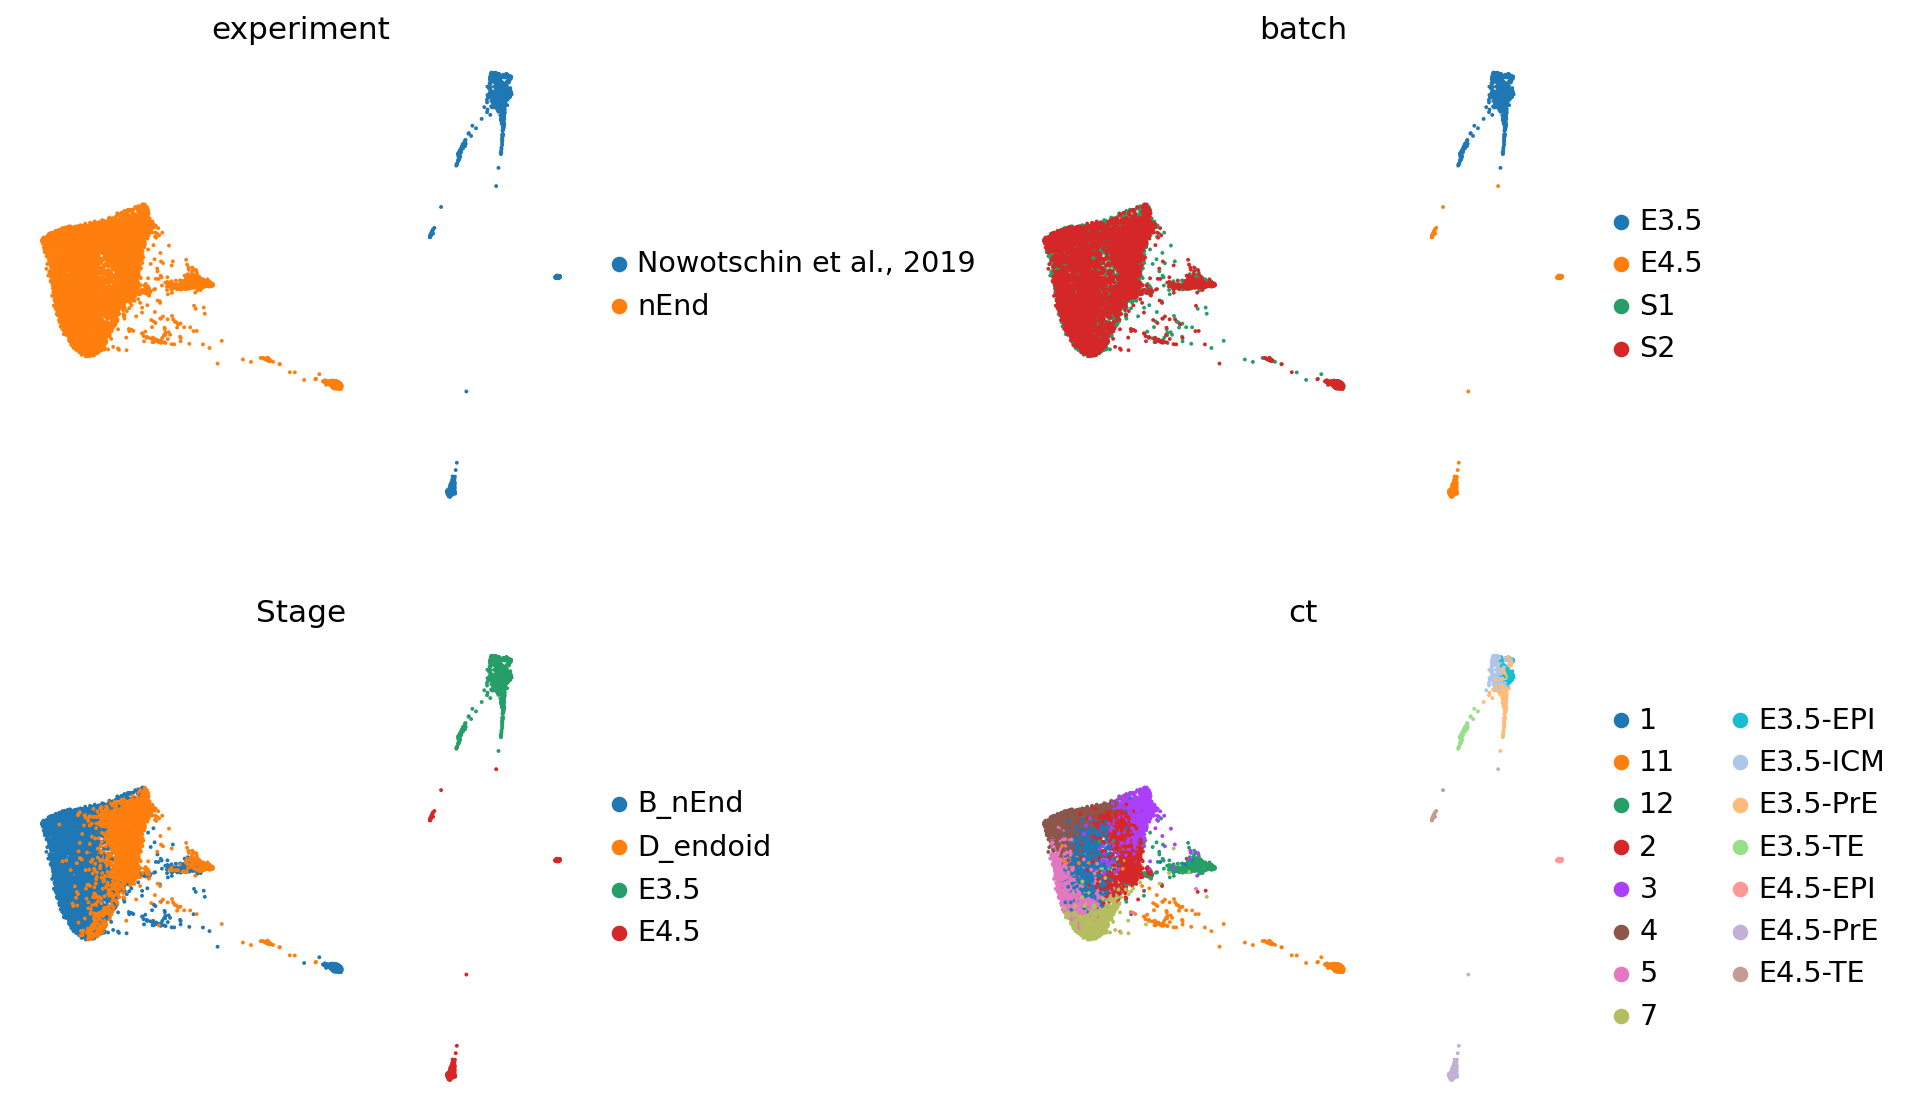

In [18]:
sc.pl.draw_graph(adata, color=['experiment', 'batch', 'Stage', 'ct'], frameon=False, 
                 wspace=0.6, ncols=2, legend_loc='right margin', save='harmony')

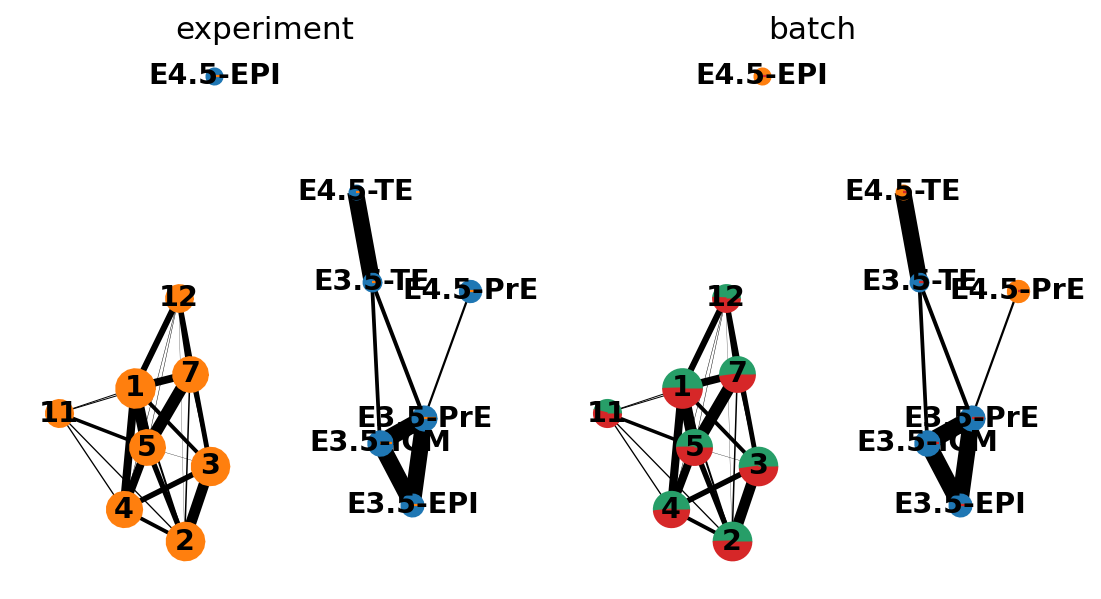

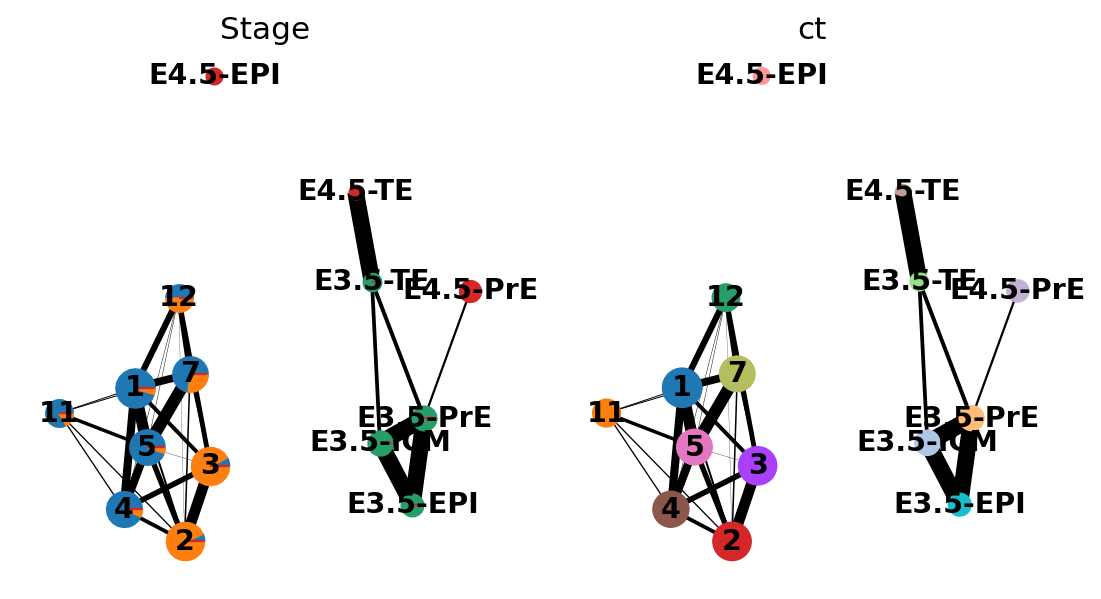

In [19]:
sc.pl.paga(adata, color=['experiment', 'batch'], frameon=False, save='harmony_1')
sc.pl.paga(adata, color=['Stage', 'ct'], frameon=False, save='harmony_2')

In [20]:
adata.write("../data/processed/08_harmony.h5ad")

In [21]:
# sce.pp.harmony_integrate(adata, key='experiment')
# sc.pp.neighbors(integ, use_rep="X_pca_harmony", key_added="harmony")

# sc.tl.umap(integ, neighbors_key="harmony")
# integ.obsm["X_harmony"] = integ.obsm["X_umap"]

# sc.pl.umap(integ, color=['experiment', 'batch', 'Stage', 'ct'], frameon=False, wspace=0.4, ncols=2)

## 2. SCVI

In [22]:
adata = integ.copy()

In [23]:
# sc.pp.highly_variable_genes(
#     adata,
#     flavor="seurat_v3",
#     n_top_genes=2_000,
#     layer="counts",
#     batch_key="experiment",
#     subset=True
# )

In [24]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key=BATCH_KEY)

In [25]:
model = scvi.model.SCVI(adata, gene_likelihood="nb", dropout_rate=0.2)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: nb, latent_distribution: normal
Training status: Not Trained

In [26]:
model.train(use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [03:09<00:00,  2.11it/s, loss=563, v_num=1]


<AxesSubplot:xlabel='epoch'>

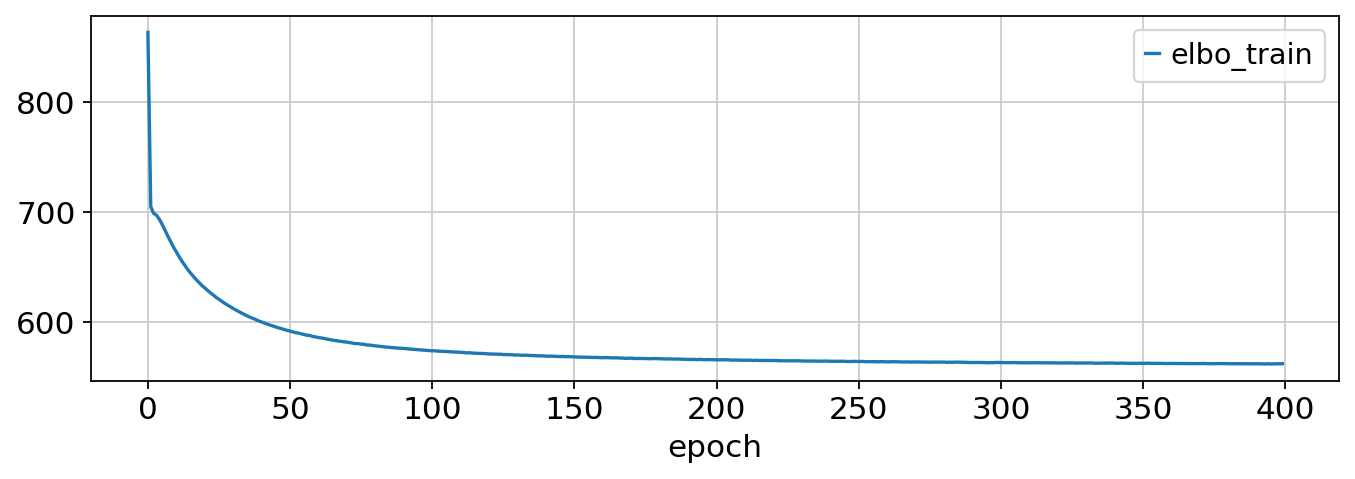

In [27]:
model.history['elbo_train'].plot(figsize=[10,3])

In [28]:
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

In [29]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

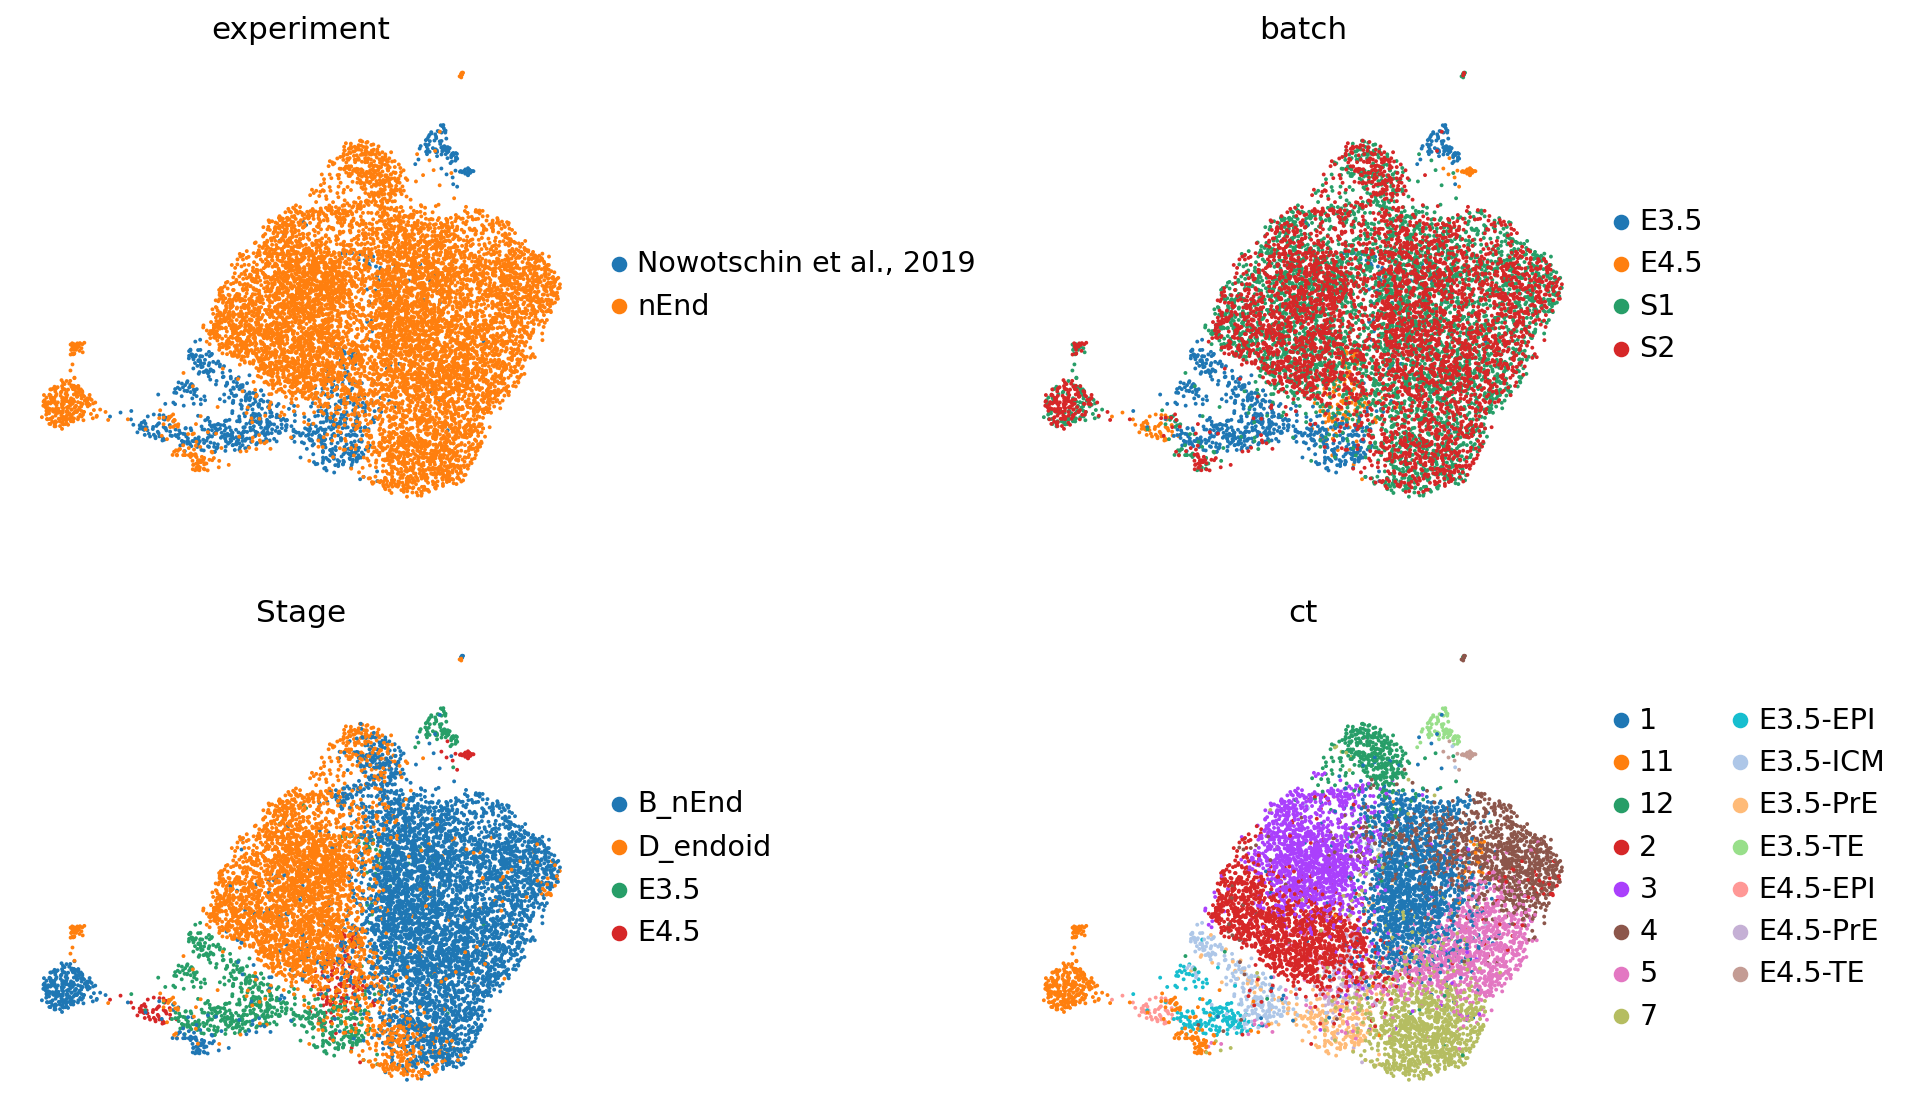

In [30]:
sc.pl.umap(adata, color=['experiment', 'batch', 'Stage', 'ct'], frameon=False, wspace=0.6, ncols=2, save='scvi')

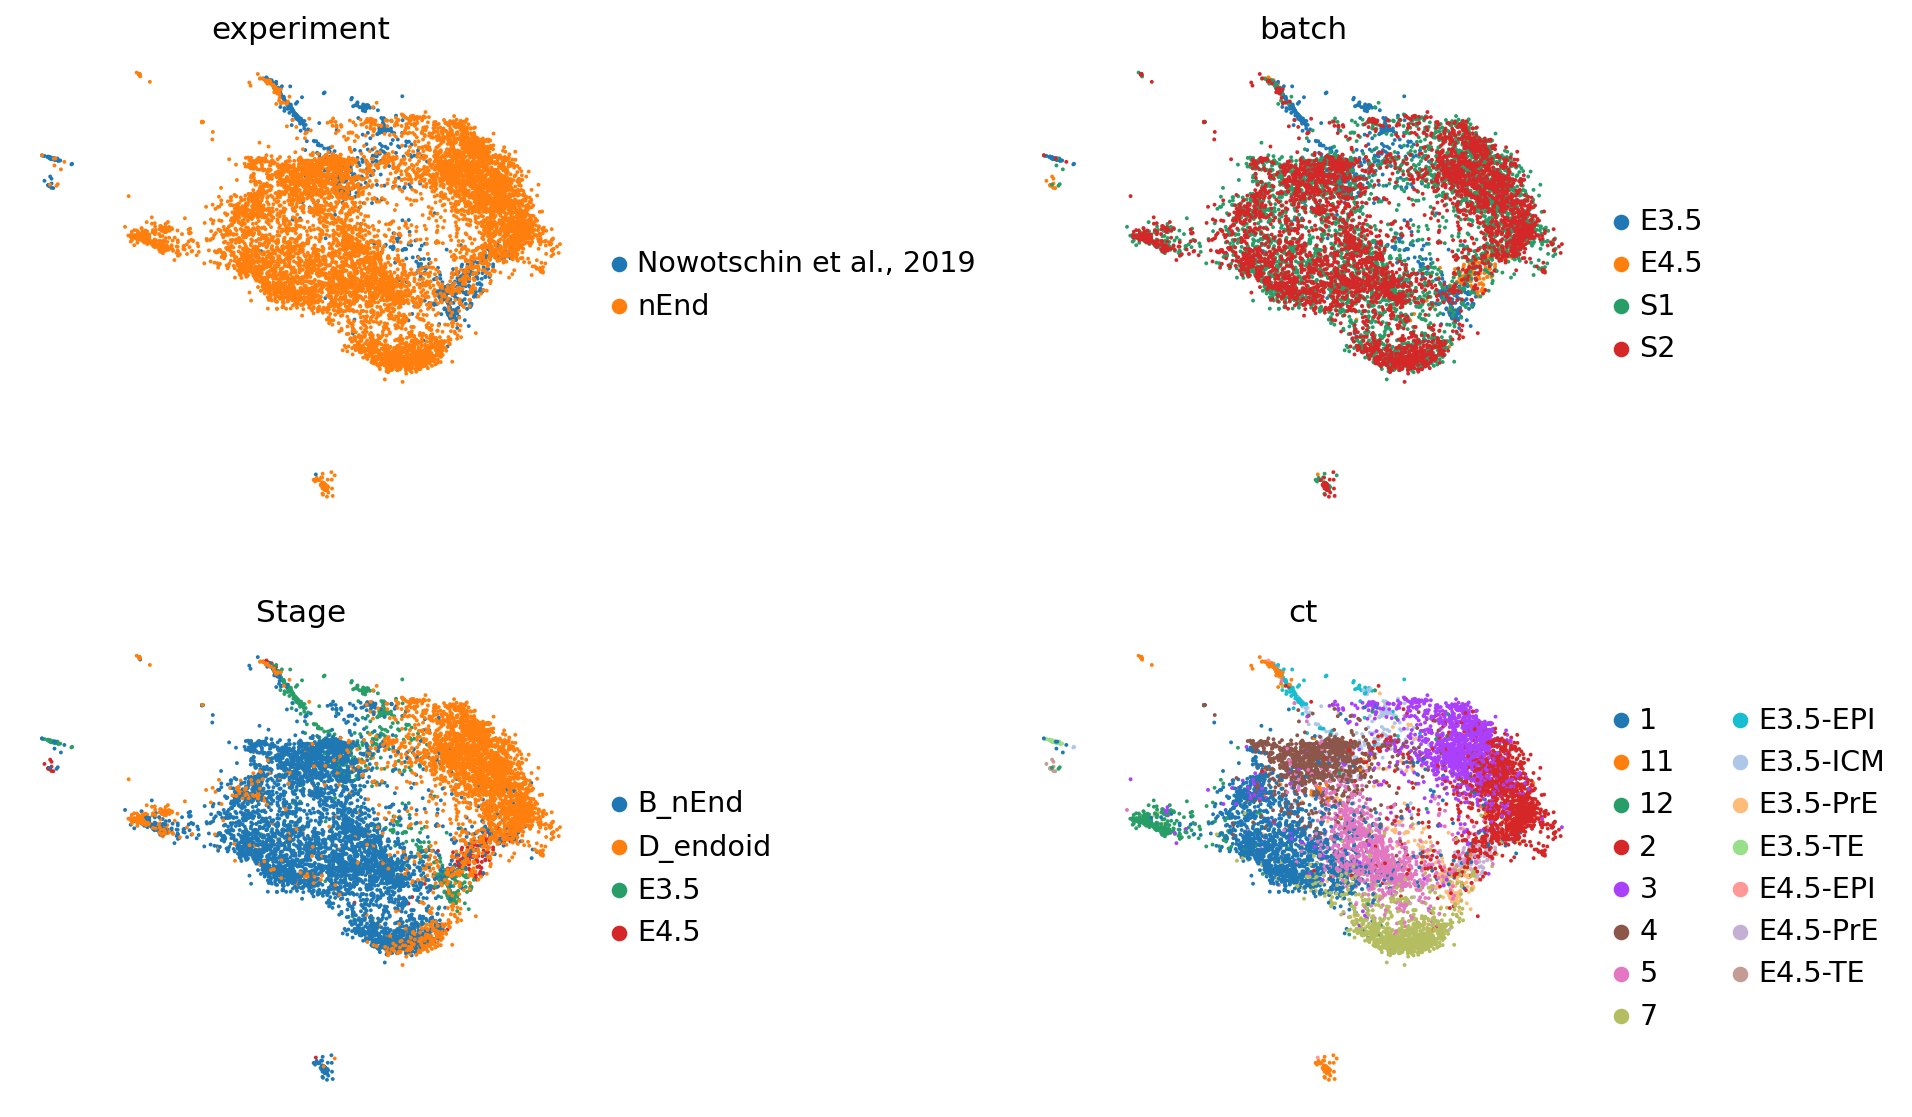

In [31]:
sc.pl.embedding(adata, basis="X_mde", color=['experiment', 'batch', 'Stage', 'ct'], frameon=False, wspace=0.6, ncols=2, save='scvi')

In [32]:
# temporary for the PAGA
adata.obsm['X_pca_old'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_scVI']

In [33]:
sc.tl.draw_graph(adata)
sc.tl.paga(adata, groups='ct')

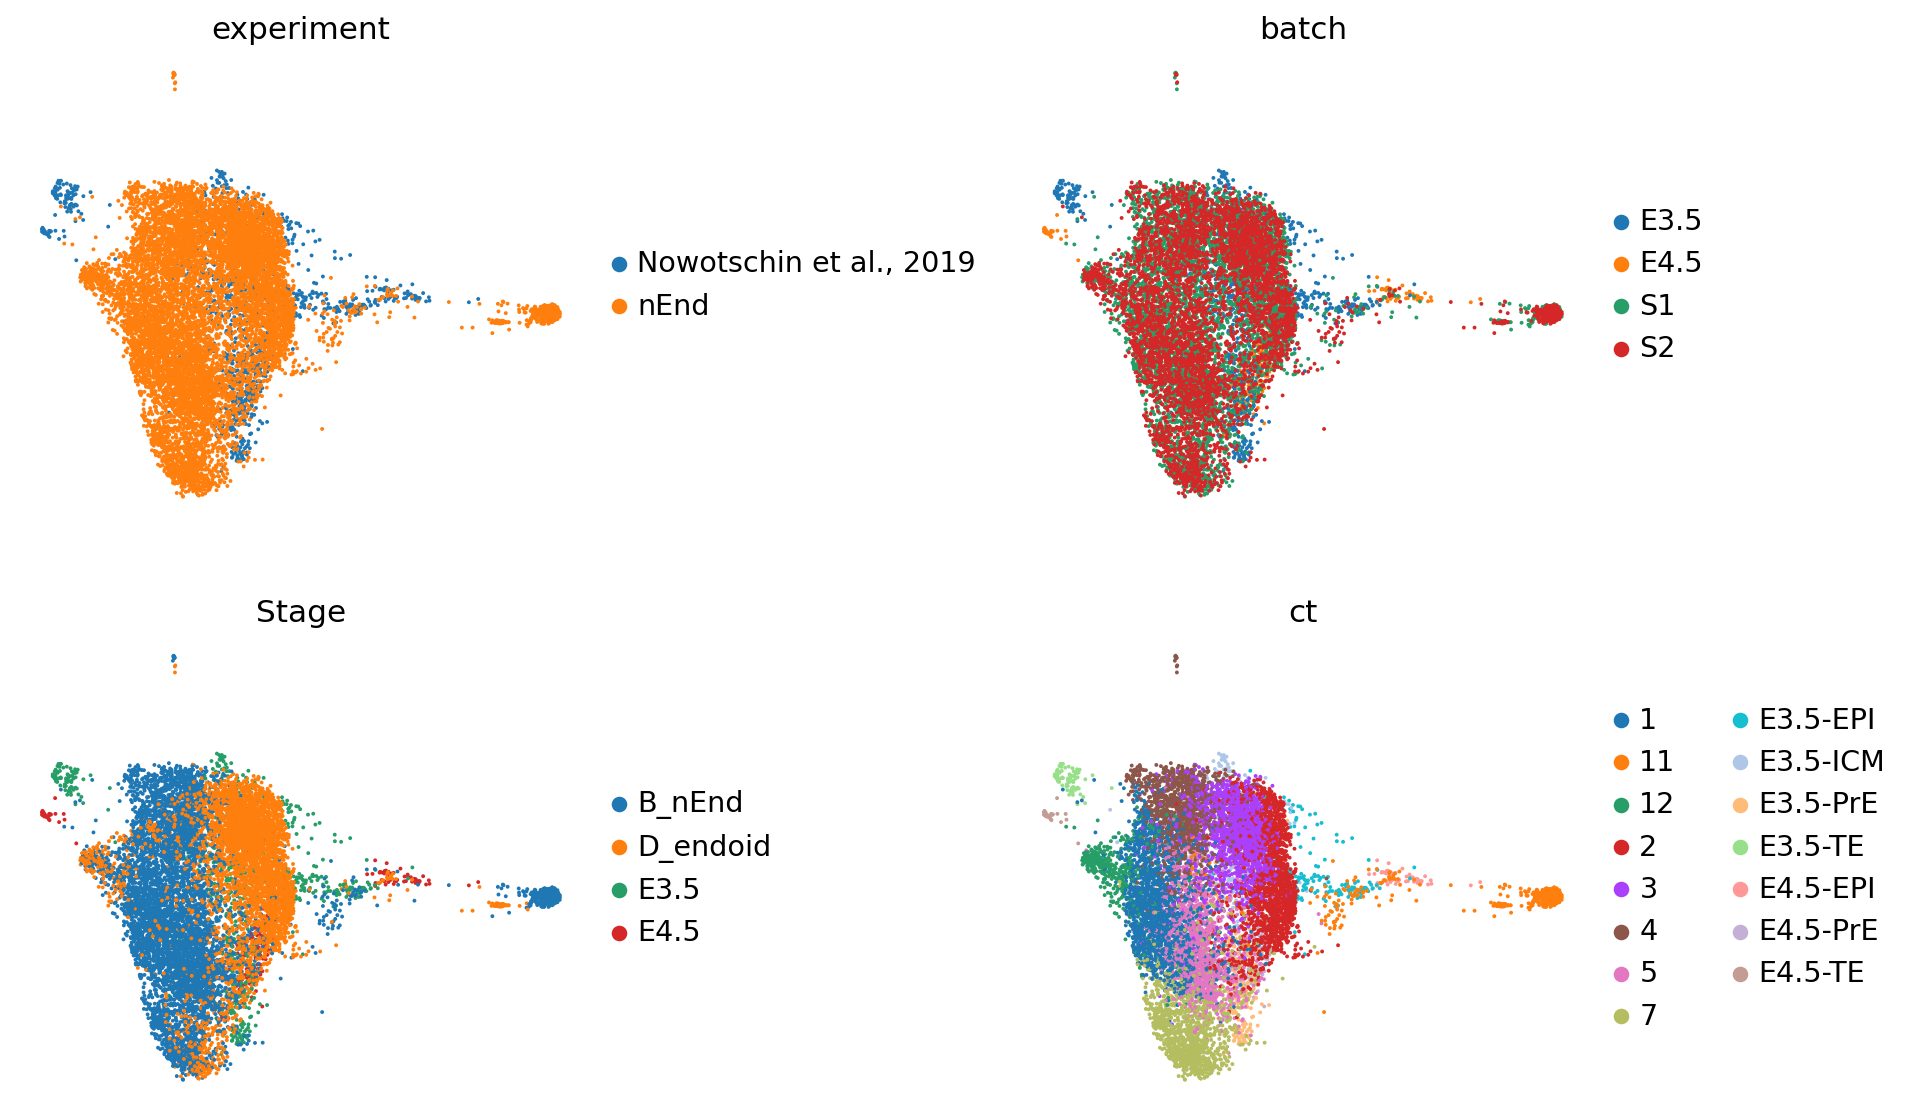

In [34]:
sc.pl.draw_graph(adata, color=['experiment', 'batch', 'Stage', 'ct'], frameon=False, 
                 wspace=0.6, ncols=2, legend_loc='right margin', save='scvi')

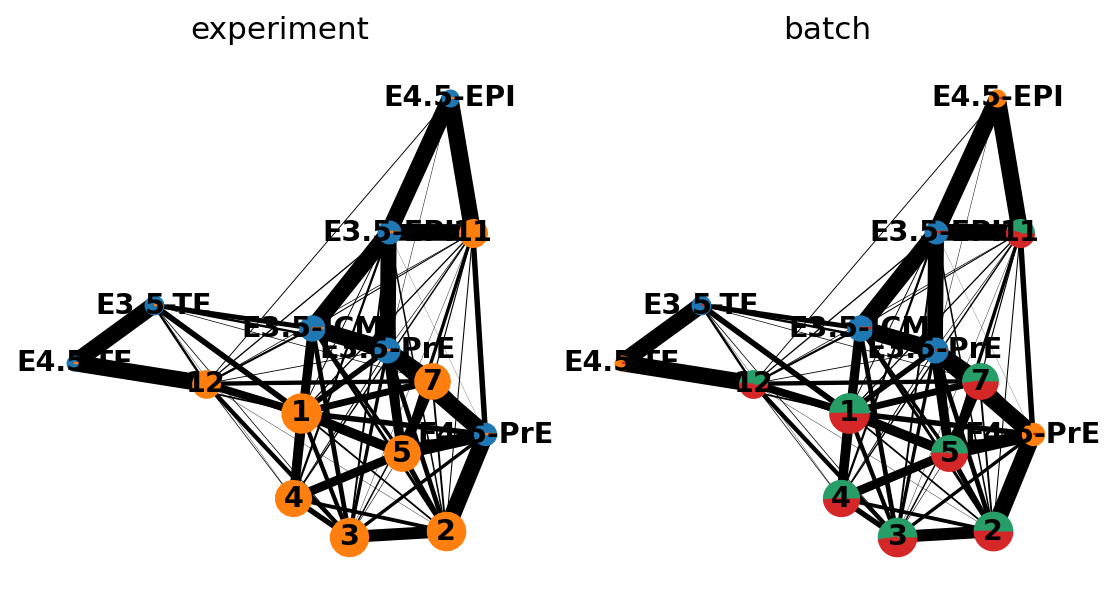

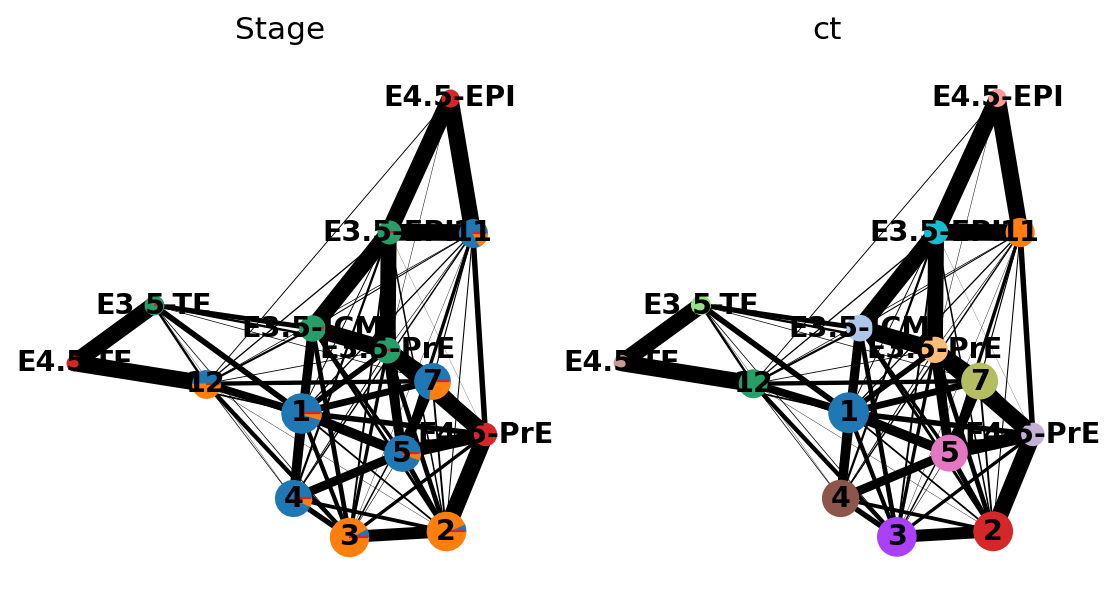

In [35]:
sc.pl.paga(adata, color=['experiment', 'batch'], frameon=False, save='scvi_1')
sc.pl.paga(adata, color=['Stage', 'ct'], frameon=False, save='scvi_2')

In [36]:
model.save("../results/08_scvi", overwrite=True, save_anndata=True)

## 3. bbknn

In [37]:
adata = integ.copy()

In [38]:
sc.external.pp.bbknn(adata, batch_key=BATCH_KEY)
sc.tl.umap(adata)

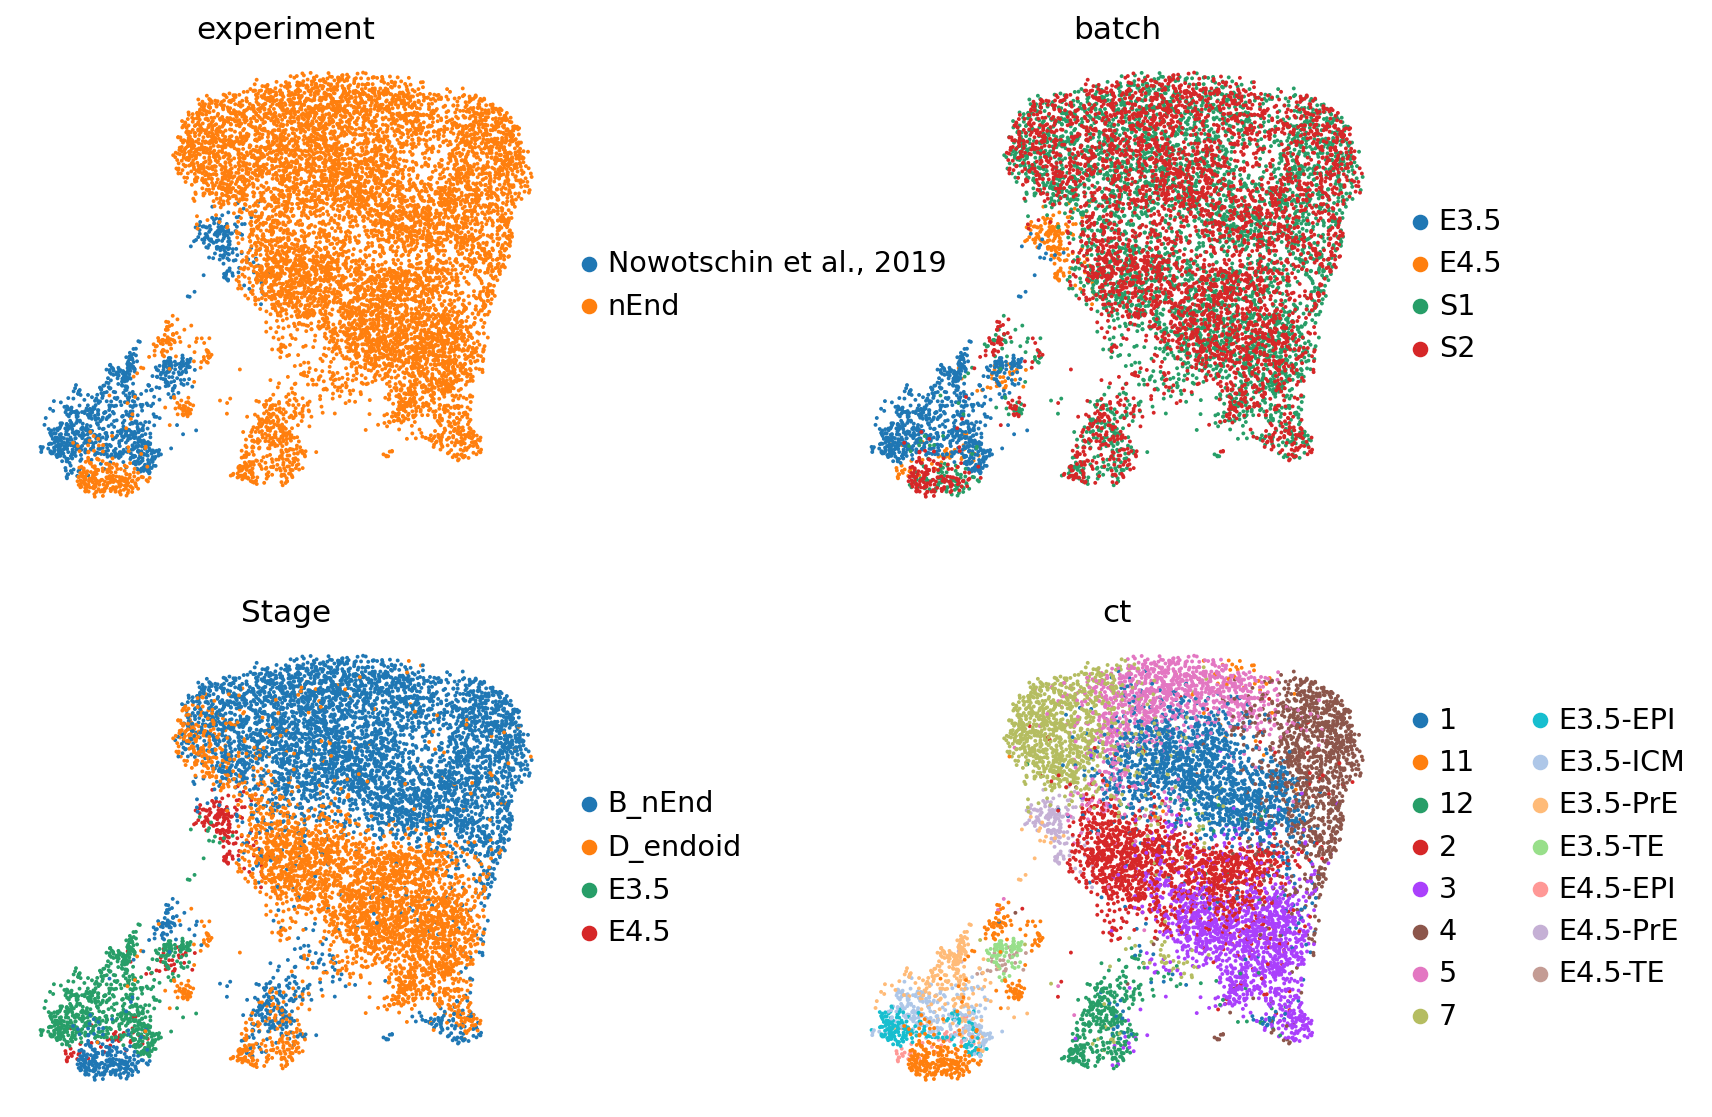

In [39]:
sc.pl.umap(adata, color=['experiment', 'batch', 'Stage', 'ct'], frameon=False, wspace=0.4, ncols=2, save='bbknn')

In [40]:
sc.tl.draw_graph(adata)
sc.tl.paga(adata, groups='ct')

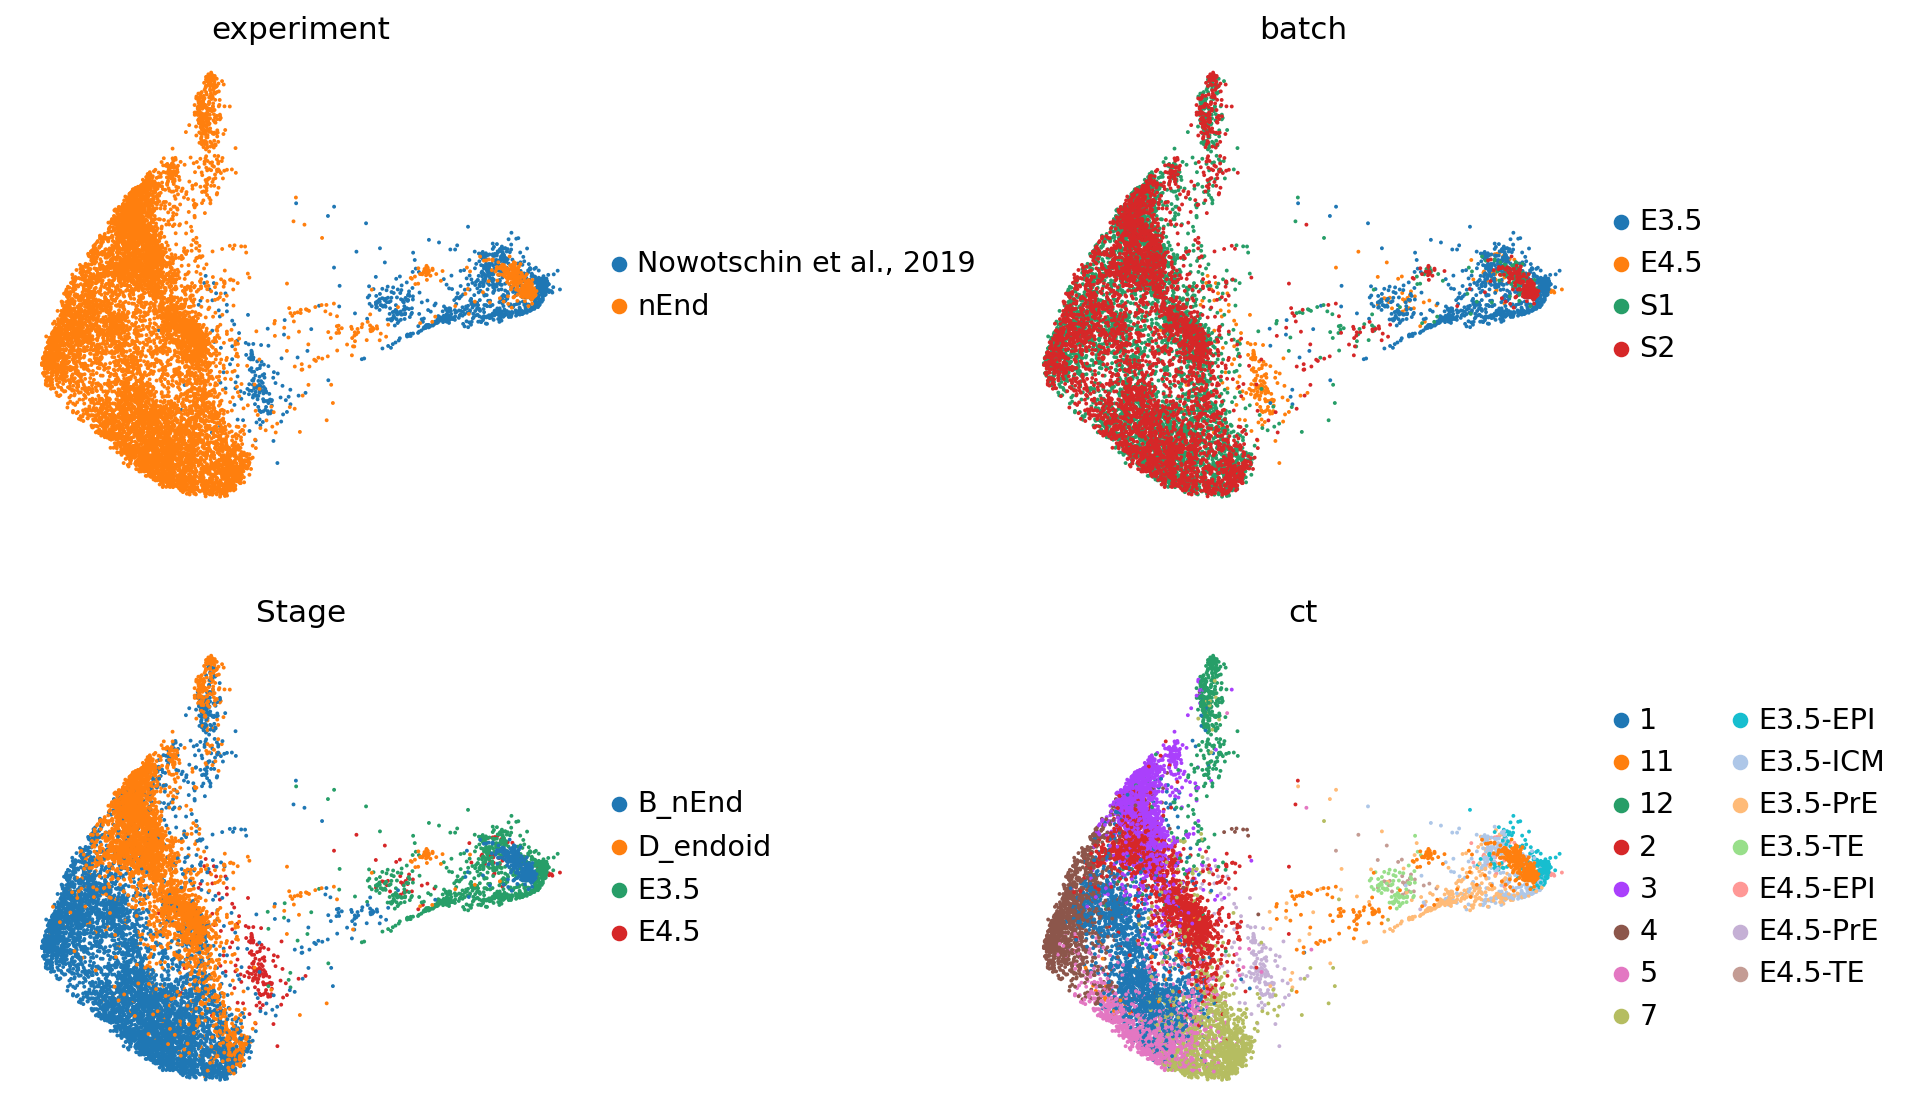

In [41]:
sc.pl.draw_graph(adata, color=['experiment', 'batch', 'Stage', 'ct'], frameon=False, 
                 wspace=0.6, ncols=2, legend_loc='right margin', save='bbknn')

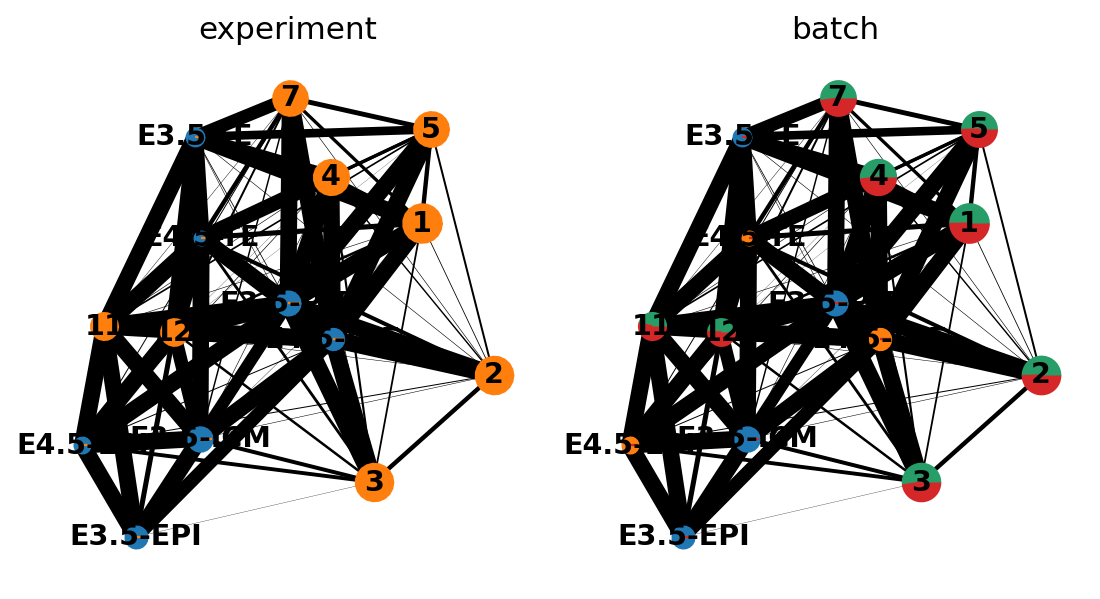

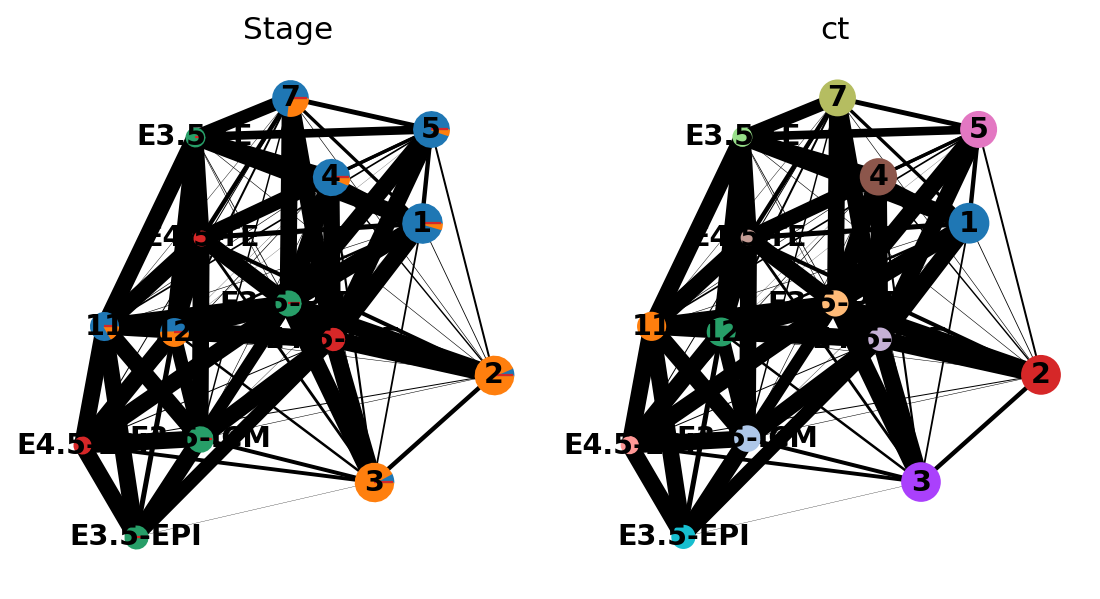

In [42]:
sc.pl.paga(adata, color=['experiment', 'batch'], frameon=False, save='bbknn_1')
sc.pl.paga(adata, color=['Stage', 'ct'], frameon=False, save='bbknn_2')

In [43]:
adata.write("../data/processed/08_bbknn.h5ad")

## 4.Metrics

In [44]:
import scib
import warnings

warnings.simplefilter("ignore", ResourceWarning)
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [55]:
# SCVI
adata_scvi = scvi.model.SCVI.load("../results/08_scvi").adata.copy()
adata_scvi.obsm["X_emb"] = adata_scvi.obsm["X_scVI"]
stats_scvi = [
    scib.metrics.graph_connectivity(adata_scvi, label_key="ct"),
    scib.metrics.silhouette_batch(adata_scvi, batch_key="batch", group_key="ct", embed="X_scVI"),
    scib.metrics.silhouette(adata_scvi, group_key="ct", embed="X_scVI"),
    scib.metrics.ilisi_graph(adata_scvi, batch_key="batch", type_="embed", n_cores=6),
    scib.metrics.kBET(adata_scvi, batch_key="batch", label_key="ct", embed="X_scVI", type_="embed")
]

# HARMONY
adata_harmony = sc.read("../data/processed/08_harmony.h5ad")
adata_harmony.obsm["X_emb"] = adata_harmony.obsm["X_pca_harmony"]
stats_harmony = [
    scib.metrics.graph_connectivity(adata_harmony, label_key="ct"),
    scib.metrics.silhouette_batch(adata_harmony, batch_key="batch", group_key="ct", embed="X_pca_harmony"),
    scib.metrics.silhouette(adata_harmony, group_key="ct", embed="X_pca_harmony"),
    scib.metrics.ilisi_graph(adata_harmony, batch_key="batch", type_="embed", n_cores=6),
    scib.metrics.kBET(adata_harmony, batch_key="batch", label_key="ct", embed="X_pca_harmony", type_="embed"),
]

# BBKNN
adata_bbknn = sc.read("../data/processed/08_bbknn.h5ad")
stats_bbknn = [
    scib.metrics.graph_connectivity(adata_bbknn, label_key="ct"),
    scib.metrics.silhouette_batch(adata_bbknn, batch_key="batch", group_key="ct", embed="X_pca"),
    scib.metrics.silhouette(adata_bbknn, group_key="ct", embed="X_pca"),
    scib.metrics.ilisi_graph(adata_bbknn, batch_key="batch", type_="knn", n_cores=6),
    scib.metrics.kBET(adata_bbknn, batch_key="batch", label_key="ct", embed="X_pca", type_="knn")
]

INFO     File ../results/08_scvi/model.pt already downloaded                                 


/projects/dan1/people/fdb589/envs/scvi-0.17.1/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


mean silhouette per group:        silhouette_score
group                  
1              0.972419
11             0.925182
12             0.984678
2              0.972198
3              0.970596
4              0.958759
5              0.943181
7              0.950288
E4.5-PrE consists of a single batch or is too small. Skip.
E4.5-EPI consists of a single batch or is too small. Skip.
E4.5-TE consists of a single batch or is too small. Skip.
E3.5-PrE consists of a single batch or is too small. Skip.
E3.5-ICM consists of a single batch or is too small. Skip.
E3.5-EPI consists of a single batch or is too small. Skip.
E3.5-TE consists of a single batch or is too small. Skip.
mean silhouette per group:        silhouette_score
group                  
1              0.978624
11             0.919536
12             0.995905
2              0.979106
3              0.977425
4              0.976983
5              0.977570
7              0.979523
E4.5-PrE consists of a single batch or is too small. Sk

<AxesSubplot:>

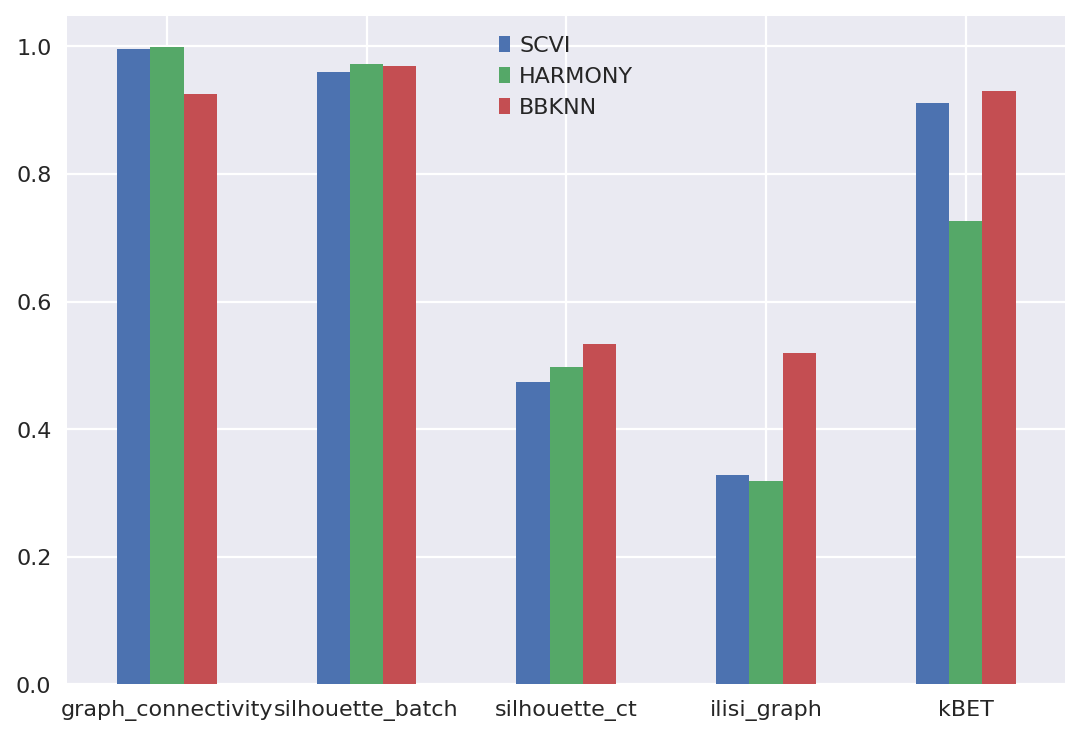

In [56]:
import matplotlib
matplotlib.style.use('seaborn')

stats_all = pd.DataFrame([stats_scvi, stats_harmony, stats_bbknn], index=['SCVI', 'HARMONY', 'BBKNN'],
                         columns=['graph_connectivity', 'silhouette_batch', 'silhouette_ct', 'ilisi_graph', 'kBET'])
stats_all.T.plot.bar(rot=0)

In [57]:
stats_all.style.highlight_max(axis=0, color="lightgreen")

In [58]:
!jupyter nbconvert --to html 08_nowo.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 08_nowo.ipynb to html
[NbConvertApp] Writing 6762211 bytes to ../reports/08_nowo.html
